In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost
import shap
import pickle

c:\Users\esrpi\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
# ONLY USE IF DATASET IS AVAILABLE
df_stats_clean = pd.read_csv('dataset_new_clean.csv',sep=";")

In [2]:
df = pd.read_pickle('clean/inactive_list_cleaned.p')
df = df.reset_index()
df = df.drop(columns=['index'],axis=1)
df['Season']=pd.DatetimeIndex(df['Date']).year
df.head()

,Date,Team,Notes,Player,on_IL,Season
0,2013-10-29,Orlando Magic,placed on IL,Hedo Turkoglu,1,2013
1,2013-10-29,Washington Wizards,placed on IL with strained right hip flexor,Otto Porter,1,2013
2,2013-10-29,Orlando Magic,placed on IL recovering from surgery to repair...,Glen Davis,1,2013
3,2013-10-29,Phoenix Suns,placed on IL recovering from surgery on neck t...,Emeka Okafor,1,2013
4,2013-10-29,Los Angeles Lakers,placed on IL recovering from surgery to repair...,Kobe Bryant,1,2013


In [63]:
df_stats = pd.read_pickle('clean/player_stats_cleaned.p')
df_stats = df_stats.reset_index()
df_stats = df_stats.drop(columns=['index'], axis=1)
df_stats['target'] = 0

def label_target():
    for i,r in df_stats.iterrows():
        on_il = np.sum(df[(df.Player==r.Player) & (df.Season == r.Year)]['on_IL'])
        df_stats.at[i,'target'] = int(on_il>0)

label_target()

In [64]:
df_stats.head()

,Year,Player,Season,Team,Age,Inches,Weight,GP,MIN,REB,...,PLAYER_ID,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,BOX_OUTS,OFF_BOXOUTS,DEF_BOXOUTS,DEFLECTIONS,CHARGES_DRAWN,target
0,2013,AJ Price,regular,Minnesota Timberwolves,27,74,195,28,3.5,0.4,...,201985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2013,Aaron Brooks,regular,Denver Nuggets,29,72,161,72,21.6,1.9,...,201166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2013,Aaron Gray,regular,Sacramento Kings,29,84,270,37,9.6,3.0,...,201189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2013,Adonis Thomas,regular,Philadelphia 76ers,21,79,240,6,6.3,0.5,...,203519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2013,Al Harrington,regular,Washington Wizards,34,81,245,34,15.0,2.4,...,1733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [65]:
df_stats.describe()

,Year,Age,Inches,Weight,GP,MIN,REB,OREB,DREB,BLK,...,PLAYER_ID,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,BOX_OUTS,OFF_BOXOUTS,DEF_BOXOUTS,DEFLECTIONS,CHARGES_DRAWN,target
count,6612.000000,6612.000000,6612.000000,6612.000000,6612.000000,6612.000000,6612.000000,6612.000000,6612.000000,6612.000000,...,6.612000e+03,6612.000000,6612.000000,6612.000000,6612.000000,6612.000000,6612.000000,6612.000000,6612.000000,6612.000000
mean,2017.143224,26.778433,78.750907,218.945856,36.842257,19.636978,3.531685,0.835662,2.698321,0.386388,...,6.955451e+05,3.393256,2.086346,1.306971,0.816101,0.114944,0.701101,0.813693,0.033690,0.614489
std,2.592980,4.282252,3.429140,25.482779,28.155860,10.346628,2.576601,0.811207,1.941112,0.437436,...,7.030888e+05,3.345064,2.366568,1.253458,1.507148,0.320462,1.268322,0.875519,0.083491,0.486753
min,2013.000000,19.000000,69.000000,150.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.080000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.000000,23.000000,76.000000,200.000000,8.000000,11.100000,1.700000,0.300000,1.300000,0.100000,...,2.019428e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017.000000,26.000000,79.000000,219.000000,33.000000,19.200000,3.000000,0.600000,2.300000,0.300000,...,2.034810e+05,2.850000,1.500000,1.130000,0.140000,0.000000,0.130000,0.600000,0.000000,1.000000
75%,2019.000000,30.000000,81.000000,238.000000,65.000000,28.400000,4.800000,1.100000,3.700000,0.500000,...,1.627814e+06,5.550000,3.170000,2.190000,0.990000,0.060000,0.850000,1.330000,0.030000,1.000000
max,2021.000000,43.000000,90.000000,360.000000,83.000000,44.000000,16.300000,5.800000,12.000000,4.000000,...,1.630994e+06,21.140000,15.780000,9.250000,16.170000,5.820000,13.000000,5.000000,1.000000,1.000000


In [66]:
# 61% of injuries, 39% of non-injuries
100*(df_stats['target'].value_counts().values/df_stats.shape[0])

array([61.44888082, 38.55111918])

In [67]:
df_stats_clean = df_stats.drop(columns=[
    'Player',
    'Season',
    'Team',
    'PLAYER_ID',
    'Year'],axis=1)
df_stats_clean.head()

,Age,Inches,Weight,GP,MIN,REB,OREB,DREB,BLK,PF,...,AVG_SPEED_DEF,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,BOX_OUTS,OFF_BOXOUTS,DEF_BOXOUTS,DEFLECTIONS,CHARGES_DRAWN,target
0,27,74,195,28,3.5,0.4,0.0,0.3,0.0,0.2,...,3.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,29,72,161,72,21.6,1.9,0.6,1.3,0.2,2.0,...,3.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,29,84,270,37,9.6,3.0,1.1,1.9,0.2,1.7,...,3.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,21,79,240,6,6.3,0.5,0.0,0.5,0.0,1.0,...,4.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,34,81,245,34,15.0,2.4,0.4,1.9,0.0,2.1,...,3.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [98]:
df_stats_clean.to_csv('dataset_new_clean.csv',sep=';',index=False)

<AxesSubplot:>

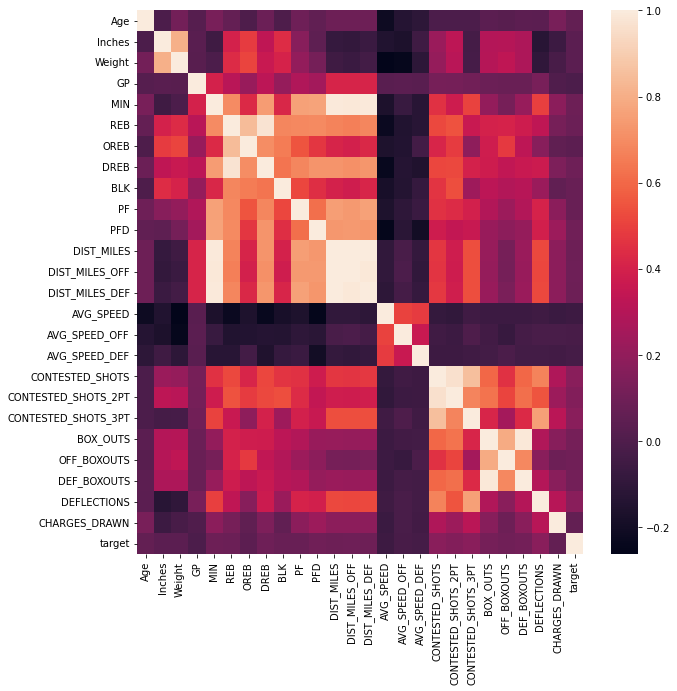

In [81]:
plt.figure(figsize=(10,10))
sns.heatmap(df_stats_clean.corr())

In [10]:
from sklearn.model_selection import train_test_split

X = df_stats_clean.drop(columns=['target'],axis=1)
y = df_stats_clean['target'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

In [11]:
model = xgboost.XGBClassifier().fit(X_train,y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[02:37:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [16]:
predictions = model.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(y_test, predictions)

array([[ 367,  464],
       [ 350, 1001]], dtype=int64)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


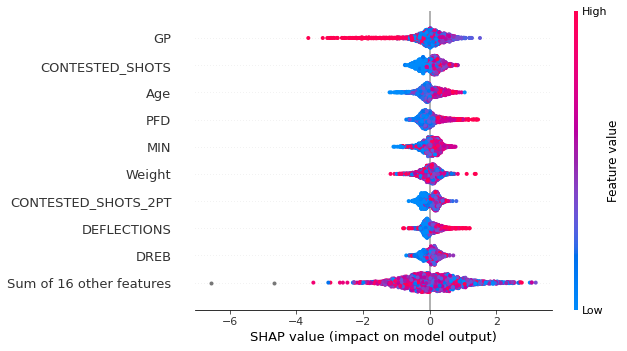

In [18]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

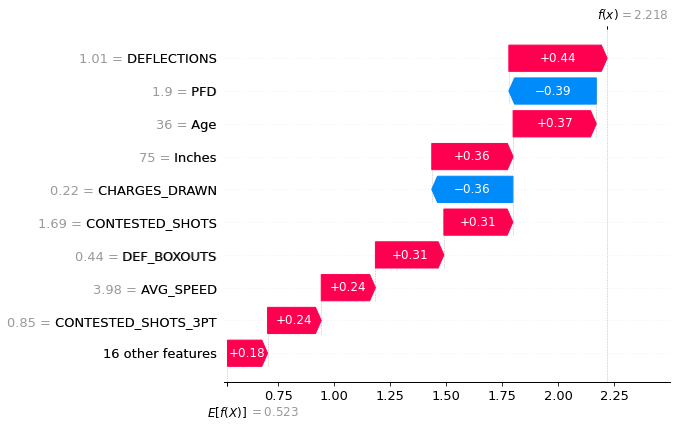

a


In [23]:
plt.figure(figsize=(6,6))
shap.plots.waterfall(shap_values[0])

print('a')